# Подготовка эксперимента

## Монтирование диска Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
from datetime import datetime

# Пусть на диске
project_dir = "/content/drive/MyDrive/nlp_test"
runs_dir = os.path.join(project_dir, "runs")
os.makedirs(runs_dir, exist_ok=True)

# Время запуска
run_id = datetime.now().strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(runs_dir, run_id)

# Папки для результатов
os.makedirs(run_dir, exist_ok=True)
os.makedirs(os.path.join(run_dir, "logs"), exist_ok=True)

print("Папка проекта:", project_dir)
print("Для экспериментов:", run_dir)


Mounted at /content/drive
Папка проекта: /content/drive/MyDrive/nlp_test
Для экспериментов: /content/drive/MyDrive/nlp_test/runs/2026-01-10_16-41


## Установка зависимостей и проверка работоспособности

In [ ]:
!pip -q install -U pip
!pip -q install datasets transformers evaluate scikit-learn pandas numpy tqdm psutil

!pip -q install textattack

!pip -q install augly nlpaug

!git clone --depth 1 https://github.com/marcotcr/checklist.git
!pip -q install munch pycountry

!pip -q uninstall -y pattern  >/dev/null 2>&1
!pip -q install https://github.com/clips/pattern/archive/python3.zip

import os, time, psutil, random
import numpy as np
import pandas as pd
import sys
sys.path.append("/content/checklist")

import pattern.text.en as en
sys.modules["pattern.en"] = en

from checklist.perturb import Perturb
import augly.text as textaugs
import textattack


print("CheckList typo:", Perturb.add_typos("This movie was terrible."))
print("AugLy zwsp:", textaugs.insert_zero_width_chars("This movie was terrible.")[0])
print("TextAttack module:", textattack)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 82.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyp

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/

CheckList typo: This movi ewas terrible.
AugLy zwsp: T⁢h⁢i⁢s⁢ ⁢m⁢o⁢v⁢i⁢e⁢ ⁢w⁢a⁢s⁢ ⁢t⁢e⁢r⁢r⁢i⁢b⁢l⁢e⁢.
TextAttack module: <module 'textattack' from '/usr/local/lib/python3.12/dist-packages/textattack/__init__.py'>


## Конфигурация эксперимента

In [ ]:
eval_size = 400
train_size = 20000
seeds = [42, 43, 44, 45, 46]

# 3 датасета: SST-2, IMDb, Emotion
# 3 HF-модели fine-tuned под каждый датасет
DATASET_SPECS = [
    {
        "dataset_key": "sst2",
        "dataset_hf_id": "glue/sst2",
        "load_args": ("glue", "sst2"),
        "train_split": "train",
        "eval_split": "validation",
        "text_col": "sentence",
        "label_col": "label",
        "hf_model_name": "distilbert-base-uncased-finetuned-sst-2-english",
    },
    {
        "dataset_key": "imdb",
        "dataset_hf_id": "imdb",
        "load_args": ("imdb",),
        "train_split": "train",
        "eval_split": "test",
        "text_col": "text",
        "label_col": "label",
        "hf_model_name": "lvwerra/distilbert-imdb",
    },
    {
        "dataset_key": "emotion",
        "dataset_hf_id": "dair-ai/emotion",
        "load_args": ("dair-ai/emotion",),
        "train_split": "train",
        "eval_split": "validation",
        "text_col": "text",
        "label_col": "label",
        "hf_model_name": "transformersbook/distilbert-base-uncased-finetuned-emotion",
    },
]

print("Datasets:", [d["dataset_hf_id"] for d in DATASET_SPECS])
print("HF models:", [d["hf_model_name"] for d in DATASET_SPECS])


Datasets: ['glue/sst2', 'imdb', 'dair-ai/emotion']
HF models: ['distilbert-base-uncased-finetuned-sst-2-english', 'lvwerra/distilbert-imdb', 'transformersbook/distilbert-base-uncased-finetuned-emotion']


## Вспомогательные функции и подготовка метрик

In [ ]:
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import torch
from sklearn.metrics import accuracy_score, f1_score

# Установка seed
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    try:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

# Вычисление метрик для многоклассовой классификации
def compute_acc_f1(y_true, y_pred):
    acc = float(accuracy_score(y_true, y_pred))
    uniq = set(int(x) for x in y_true)
    if len(uniq) <= 2:
        f1 = float(f1_score(y_true, y_pred))
        f1_avg = "binary"
    else:
        f1 = float(f1_score(y_true, y_pred, average="macro"))
        f1_avg = "macro"
    return acc, f1, f1_avg


In [ ]:
import csv

def append_row_to_csv(csv_path: str, row: dict, columns: list):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    file_exists = os.path.exists(csv_path)

    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        if not file_exists:
            writer.writeheader()
        safe_row = {c: row.get(c, "") for c in columns}
        writer.writerow(safe_row)

COLUMNS = [
    "run_id", "seed", "repeat_id",
    "dataset_key", "dataset_hf_id", "hf_model_name",
    "n_labels", "f1_avg",
    "dataset", "eval_size",
    "model", "tool", "test_id",
    "n_eval", "n_ok", "fail_rate", "changed_rate", "avg_similarity",
    "invariance_rate",
    "acc", "f1",
    "acc_clean", "f1_clean", "drop_acc", "drop_f1",
    "time_sec", "peak_rss_mb",
    "attack_success_rate",
    "notes",
]

results_csv = os.path.join(run_dir, "results.csv")
print("Файл результатов:", results_csv)


Файл результатов: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/results.csv


In [ ]:
from difflib import SequenceMatcher

def calc_similarity_stats(orig_texts, new_texts):
    n_eval = len(orig_texts)

    ok_pairs = []
    for o, n in zip(orig_texts, new_texts):
        if isinstance(n, str):
            ok_pairs.append((o, n))

    n_ok = len(ok_pairs)
    fail_rate = 1.0 - (n_ok / n_eval) if n_eval > 0 else 1.0

    if n_ok == 0:
        return {
            "n_eval": n_eval,
            "n_ok": 0,
            "fail_rate": 1.0,
            "changed_rate": 0.0,
            "avg_similarity": 0.0,
        }

    changed = 0
    sim_sum = 0.0

    for o, n in ok_pairs:
        if n != o:
            changed += 1
        sim_sum += SequenceMatcher(None, o, n).ratio()

    changed_rate = changed / n_ok
    avg_similarity = sim_sum / n_ok

    return {
        "n_eval": n_eval,
        "n_ok": n_ok,
        "fail_rate": fail_rate,
        "changed_rate": changed_rate,
        "avg_similarity": avg_similarity,
    }


In [ ]:
from datasets import load_dataset

def load_splits_for_spec(spec: dict):
    ds = load_dataset(*spec["load_args"])

    train_split = spec["train_split"]
    eval_split = spec["eval_split"]

    if train_split not in ds:
        train_split = list(ds.keys())[0]

    if eval_split not in ds:
        eval_split = "test" if "test" in ds else train_split

    return ds[train_split], ds[eval_split], train_split, eval_split

def sample_texts_labels(split, text_col: str, label_col: str, n: int, seed: int):
    idx = list(range(len(split)))
    set_seed(seed)
    random.shuffle(idx)
    idx = idx[:min(n, len(idx))]

    texts = [split[i][text_col] for i in idx]
    labels = [int(split[i][label_col]) for i in idx]
    return texts, labels

def infer_n_labels(train_split, label_col: str, max_scan: int = 5000):
    k = min(len(train_split), max_scan)
    labs = [int(train_split[i][label_col]) for i in range(k)]
    return len(set(labs))


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModelForSequenceClassification

def train_sklearn_model(train_texts, train_labels):
    sk_model = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=50000)),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    t0 = time.time()
    sk_model.fit(train_texts, train_labels)
    train_time = time.time() - t0
    return sk_model, float(train_time)

def load_hf_model(hf_model_name: str):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    hf_model = AutoModelForSequenceClassification.from_pretrained(hf_model_name)
    hf_model.to(device)
    hf_model.eval()
    return hf_model, tokenizer, device


In [ ]:
proc = psutil.Process(os.getpid())

def _rss_mb() -> float:
    return proc.memory_info().rss / (1024 * 1024)

def eval_sklearn(model, texts, labels):
    rss0 = _rss_mb()
    peak = rss0
    t0 = time.time()

    preds = model.predict(texts)

    t_sec = time.time() - t0
    peak = max(peak, _rss_mb())
    peak_delta = max(0.0, peak - rss0)

    acc, f1, f1_avg = compute_acc_f1(labels, preds)
    return {"acc": acc, "f1": f1, "f1_avg": f1_avg, "time_sec": float(t_sec), "peak_rss_mb": float(peak_delta), "preds": preds}

def hf_predict_with_peak(hf_model, tokenizer, device, texts, batch_size=32, max_length=256, peak_mb_start=None):
    preds_all = []
    peak = _rss_mb() if peak_mb_start is None else peak_mb_start

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            enc = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = hf_model(**enc)
            preds = torch.argmax(out.logits, dim=-1).detach().cpu().tolist()
            preds_all.extend(preds)

            cur = _rss_mb()
            if cur > peak:
                peak = cur

    return preds_all, peak

def eval_hf(hf_model, tokenizer, texts, labels, device, batch_size=32, max_length=256):
    rss0 = _rss_mb()
    peak = rss0
    t0 = time.time()

    preds, peak = hf_predict_with_peak(hf_model, tokenizer, device, texts, batch_size=batch_size, max_length=max_length, peak_mb_start=peak)

    t_sec = time.time() - t0
    peak_delta = max(0.0, peak - rss0)

    acc, f1, f1_avg = compute_acc_f1(labels, preds)
    return {"acc": acc, "f1": f1, "f1_avg": f1_avg, "time_sec": float(t_sec), "peak_rss_mb": float(peak_delta), "preds": preds}


In [ ]:
def _safe_augly_apply(func, t: str):
    try:
        out = func(t)
        if isinstance(out, (list, tuple)):
            if len(out) == 0:
                return None
            out = out[0]
        return out if isinstance(out, str) else None
    except Exception:
        return None

aug_tests = {
    "augly_insert_punct": lambda t: _safe_augly_apply(textaugs.insert_punctuation_chars, t),
    "augly_insert_zwsp":  lambda t: _safe_augly_apply(textaugs.insert_zero_width_chars, t),
    "augly_unicode":      lambda t: _safe_augly_apply(textaugs.replace_similar_unicode_chars, t),
}
if hasattr(textaugs, "insert_whitespace_chars"):
    aug_tests["augly_insert_whitespace"] = lambda t: _safe_augly_apply(textaugs.insert_whitespace_chars, t)

print("AugLy tests:", list(aug_tests.keys()))


AugLy tests: ['augly_insert_punct', 'augly_insert_zwsp', 'augly_unicode', 'augly_insert_whitespace']


In [ ]:
def _safe_checklist_apply(func, t: str):
    try:
        out = func(t)
        if isinstance(out, (list, tuple)):
            if len(out) == 0:
                return None
            out = out[0]
        return out if isinstance(out, str) else None
    except Exception:
        return None

cl_tests = {}
if hasattr(Perturb, "add_typos"):
    cl_tests["checklist_typos"] = lambda t: _safe_checklist_apply(Perturb.add_typos, t)

print("CheckList tests:", list(cl_tests.keys()))


CheckList tests: ['checklist_typos']


In [ ]:
import nltk

nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt")

from textattack.attack_recipes import TextFoolerJin2019
from textattack.datasets import Dataset
from textattack import Attacker, AttackArgs
from textattack.attack_results import SuccessfulAttackResult, FailedAttackResult, SkippedAttackResult
from textattack.models.wrappers import HuggingFaceModelWrapper, SklearnModelWrapper

# Переменные для настройки атаки
N_ATTACK_SK = 40
N_ATTACK_HF = 10
QUERY_BUDGET = 200

BATCH_SIZE = 32
MAX_LENGTH = 256

test_id_textattack = "textattack_textfooler"

class TA_VectorizerAdapter:
    def __init__(self, vectorizer):
        self.v = vectorizer
    def transform(self, texts):
        return self.v.transform(texts)
    def get_feature_names(self):
        if hasattr(self.v, "get_feature_names_out"):
            return list(self.v.get_feature_names_out())
        return list(self.v.get_feature_names())

def run_textattack_for_wrapper(attack, texts, labels, n_attack, query_budget):
    texts_n = texts[:n_attack]
    labels_n = labels[:n_attack]

    ds_ta = Dataset(list(zip(texts_n, labels_n)))
    attack_args = AttackArgs(
        num_examples=n_attack,
        query_budget=query_budget,
        silent=True,
        disable_stdout=True,
        enable_advance_metrics=False
    )

    attacker = Attacker(attack, ds_ta, attack_args)
    results = attacker.attack_dataset()

    n_success = 0
    n_failed = 0
    n_skipped = 0

    orig_attempted = []
    final_attempted = []
    y_attempted = []

    for i, r in enumerate(results):
        orig = texts_n[i]
        y = int(labels_n[i])

        if isinstance(r, SkippedAttackResult):
            n_skipped += 1
            continue

        orig_attempted.append(orig)
        y_attempted.append(y)

        if isinstance(r, SuccessfulAttackResult):
            n_success += 1
            final_attempted.append(r.perturbed_text())
        elif isinstance(r, FailedAttackResult):
            n_failed += 1
            final_attempted.append(orig)
        else:
            n_failed += 1
            final_attempted.append(orig)

    return final_attempted, orig_attempted, y_attempted, n_skipped, n_failed, n_success

def make_stats_for_textattack(orig_attempted, final_attempted, n_attack, n_skipped):
    base = calc_similarity_stats(orig_attempted, final_attempted)
    return {
        "n_eval": n_attack,
        "n_ok": base["n_ok"],
        "fail_rate": (n_skipped / n_attack) if n_attack > 0 else 1.0,
        "changed_rate": base["changed_rate"],
        "avg_similarity": base["avg_similarity"],
    }


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Запуск эксперимента

In [ ]:
def run_one_dataset(spec: dict):
    dataset_key = spec["dataset_key"]
    dataset_hf_id = spec["dataset_hf_id"]
    hf_model_name = spec["hf_model_name"]
    dataset_str = dataset_hf_id

    print("\n" + "="*90)
    print(f"DATASET: {dataset_hf_id} | HF: {hf_model_name}")
    print("="*90)

    train_data, eval_data, train_split_name, eval_split_name = load_splits_for_spec(spec)
    n_labels = infer_n_labels(train_data, spec["label_col"])
    print(f"splits: train={train_split_name} ({len(train_data)}), eval={eval_split_name} ({len(eval_data)})")
    print("n_labels:", n_labels)

    # prepare training  SK
    seed0 = seeds[0]
    train_texts, train_labels = sample_texts_labels(train_data, spec["text_col"], spec["label_col"], train_size, seed0)

    # train SK
    sk_model, train_time = train_sklearn_model(train_texts, train_labels)
    print("SK train time (sec):", round(train_time, 2))

    # load HF
    hf_model, tokenizer, device = load_hf_model(hf_model_name)
    print("Device:", device)

    # CLEAN BASELINES
    clean_baselines = {}

    for repeat_id, seed in enumerate(seeds, start=1):
        set_seed(seed)

        texts, labels = sample_texts_labels(eval_data, spec["text_col"], spec["label_col"], eval_size, seed)

        sk_clean = eval_sklearn(sk_model, texts, labels)
        hf_clean = eval_hf(hf_model, tokenizer, texts, labels, device=device, batch_size=32, max_length=256)

        clean_baselines[repeat_id] = {
            "seed": seed,
            "texts": texts,
            "labels": labels,
            "sk": {"acc_clean": sk_clean["acc"], "f1_clean": sk_clean["f1"], "preds_clean": sk_clean["preds"], "f1_avg": sk_clean["f1_avg"]},
            "hf": {"acc_clean": hf_clean["acc"], "f1_clean": hf_clean["f1"], "preds_clean": hf_clean["preds"], "f1_avg": hf_clean["f1_avg"]},
        }

        row_sk = {
            "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
            "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
            "n_labels": n_labels, "f1_avg": sk_clean["f1_avg"],
            "dataset": dataset_str, "eval_size": len(texts),
            "model": "sk_tfidf_lr", "tool": "clean", "test_id": "clean",
            "n_eval": len(texts), "n_ok": len(texts),
            "fail_rate": 0.0, "changed_rate": 0.0, "avg_similarity": 1.0,
            "invariance_rate": 1.0,
            "acc": sk_clean["acc"], "f1": sk_clean["f1"],
            "acc_clean": sk_clean["acc"], "f1_clean": sk_clean["f1"],
            "drop_acc": 0.0, "drop_f1": 0.0,
            "time_sec": sk_clean["time_sec"], "peak_rss_mb": sk_clean["peak_rss_mb"],
            "attack_success_rate": "",
            "notes": "peak_delta_mb",
        }

        row_hf = {
            "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
            "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
            "n_labels": n_labels, "f1_avg": hf_clean["f1_avg"],
            "dataset": dataset_str, "eval_size": len(texts),
            "model": "hf_distilbert", "tool": "clean", "test_id": "clean",
            "n_eval": len(texts), "n_ok": len(texts),
            "fail_rate": 0.0, "changed_rate": 0.0, "avg_similarity": 1.0,
            "invariance_rate": 1.0,
            "acc": hf_clean["acc"], "f1": hf_clean["f1"],
            "acc_clean": hf_clean["acc"], "f1_clean": hf_clean["f1"],
            "drop_acc": 0.0, "drop_f1": 0.0,
            "time_sec": hf_clean["time_sec"], "peak_rss_mb": hf_clean["peak_rss_mb"],
            "attack_success_rate": "",
            "notes": "batch_size=32; max_length=256; peak_delta_mb",
        }

        append_row_to_csv(results_csv, row_sk, COLUMNS)
        append_row_to_csv(results_csv, row_hf, COLUMNS)

        print(f"[{dataset_hf_id}] {repeat_id} seed={seed} "
              f"SK acc={sk_clean['acc']:.3f} f1={sk_clean['f1']:.3f} | "
              f"HF acc={hf_clean['acc']:.3f} f1={hf_clean['f1']:.3f}")

    # AUGLY
    for test_id, aug_fn in aug_tests.items():
        print(f"[{dataset_hf_id}] AugLy:", test_id)

        for repeat_id in sorted(clean_baselines.keys()):
            seed = clean_baselines[repeat_id]["seed"]
            texts = clean_baselines[repeat_id]["texts"]
            labels = clean_baselines[repeat_id]["labels"]

            sk_base_acc = clean_baselines[repeat_id]["sk"]["acc_clean"]
            sk_base_f1  = clean_baselines[repeat_id]["sk"]["f1_clean"]
            sk_clean_preds_full = clean_baselines[repeat_id]["sk"]["preds_clean"]

            hf_base_acc = clean_baselines[repeat_id]["hf"]["acc_clean"]
            hf_base_f1  = clean_baselines[repeat_id]["hf"]["f1_clean"]
            hf_clean_preds_full = clean_baselines[repeat_id]["hf"]["preds_clean"]

            rss0 = _rss_mb()

            peak_gen = rss0
            t_gen0 = time.time()
            new_texts = [aug_fn(t) for t in texts]
            gen_time = time.time() - t_gen0
            peak_gen = max(peak_gen, _rss_mb())

            stats = calc_similarity_stats(texts, new_texts)

            ok_texts, ok_labels, ok_orig_texts = [], [], []
            ok_sk_clean_preds, ok_hf_clean_preds = [], []

            for orig_t, t_new, y, skp, hfp in zip(texts, new_texts, labels, sk_clean_preds_full, hf_clean_preds_full):
                if isinstance(t_new, str):
                    ok_texts.append(t_new)
                    ok_orig_texts.append(orig_t)
                    ok_labels.append(int(y))
                    ok_sk_clean_preds.append(int(skp))
                    ok_hf_clean_preds.append(int(hfp))

            if len(ok_texts) == 0:
                peak_delta = max(0.0, peak_gen - rss0)

                row_sk = {
                    "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                    "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
                    "n_labels": n_labels, "f1_avg": clean_baselines[repeat_id]["sk"]["f1_avg"],
                    "dataset": dataset_str, "eval_size": len(texts),
                    "model": "sk_tfidf_lr", "tool": "augly", "test_id": test_id,
                    **stats,
                    "invariance_rate": "",
                    "acc": "", "f1": "",
                    "acc_clean": sk_base_acc, "f1_clean": sk_base_f1,
                    "drop_acc": "", "drop_f1": "",
                    "time_sec": round(gen_time, 6),
                    "peak_rss_mb": round(peak_delta, 3),
                    "attack_success_rate": "",
                    "notes": "peak_delta_mb; no_ok_texts",
                }

                row_hf = {
                    "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                    "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
                    "n_labels": n_labels, "f1_avg": clean_baselines[repeat_id]["hf"]["f1_avg"],
                    "dataset": dataset_str, "eval_size": len(texts),
                    "model": "hf_distilbert", "tool": "augly", "test_id": test_id,
                    **stats,
                    "invariance_rate": "",
                    "acc": "", "f1": "",
                    "acc_clean": hf_base_acc, "f1_clean": hf_base_f1,
                    "drop_acc": "", "drop_f1": "",
                    "time_sec": round(gen_time, 6),
                    "peak_rss_mb": round(peak_delta, 3),
                    "attack_success_rate": "",
                    "notes": "peak_delta_mb; no_ok_texts; batch_size=32; max_length=256",
                }

                append_row_to_csv(results_csv, row_sk, COLUMNS)
                append_row_to_csv(results_csv, row_hf, COLUMNS)
                continue

            # SK predict  ok_texts
            peak_sk = peak_gen
            t_sk0 = time.time()
            sk_preds = sk_model.predict(ok_texts)
            sk_time = time.time() - t_sk0
            peak_sk = max(peak_sk, _rss_mb())

            sk_acc, sk_f1, sk_f1_avg = compute_acc_f1(ok_labels, sk_preds)
            inv_sk = float(np.mean(np.array(ok_sk_clean_preds) == np.array(sk_preds)))

            peak_delta_sk = max(0.0, peak_sk - rss0)

            row_sk = {
                "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
                "n_labels": n_labels, "f1_avg": sk_f1_avg,
                "dataset": dataset_str, "eval_size": len(texts),
                "model": "sk_tfidf_lr", "tool": "augly", "test_id": test_id,
                **stats,
                "invariance_rate": inv_sk,
                "acc": sk_acc, "f1": sk_f1,
                "acc_clean": sk_base_acc, "f1_clean": sk_base_f1,
                "drop_acc": float(sk_base_acc - sk_acc),
                "drop_f1": float(sk_base_f1 - sk_f1),
                "time_sec": round(gen_time + sk_time, 6),
                "peak_rss_mb": round(peak_delta_sk, 3),
                "attack_success_rate": "",
                "notes": f"peak_delta_mb; gen+sk_time; n_ok={len(ok_texts)}",
            }
            append_row_to_csv(results_csv, row_sk, COLUMNS)

            # HF predict  ok_texts
            peak_hf = peak_gen
            t_hf0 = time.time()
            hf_preds, peak_hf = hf_predict_with_peak(hf_model, tokenizer, device, ok_texts, batch_size=32, max_length=256, peak_mb_start=peak_hf)
            hf_time = time.time() - t_hf0

            hf_acc, hf_f1, hf_f1_avg = compute_acc_f1(ok_labels, hf_preds)
            inv_hf = float(np.mean(np.array(ok_hf_clean_preds) == np.array(hf_preds)))

            peak_delta_hf = max(0.0, peak_hf - rss0)

            row_hf = {
                "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
                "n_labels": n_labels, "f1_avg": hf_f1_avg,
                "dataset": dataset_str, "eval_size": len(texts),
                "model": "hf_distilbert", "tool": "augly", "test_id": test_id,
                **stats,
                "invariance_rate": inv_hf,
                "acc": hf_acc, "f1": hf_f1,
                "acc_clean": hf_base_acc, "f1_clean": hf_base_f1,
                "drop_acc": float(hf_base_acc - hf_acc),
                "drop_f1": float(hf_base_f1 - hf_f1),
                "time_sec": round(gen_time + hf_time, 6),
                "peak_rss_mb": round(peak_delta_hf, 3),
                "attack_success_rate": "",
                "notes": "peak_delta_mb; gen+hf_time; batch_size=32; max_length=256",
            }
            append_row_to_csv(results_csv, row_hf, COLUMNS)

    # CHECKLIST
    for test_id, cl_fn in cl_tests.items():
        print(f"[{dataset_hf_id}] CheckList:", test_id)

        for repeat_id in sorted(clean_baselines.keys()):
            seed = clean_baselines[repeat_id]["seed"]
            texts = clean_baselines[repeat_id]["texts"]
            labels = clean_baselines[repeat_id]["labels"]

            sk_base_acc = clean_baselines[repeat_id]["sk"]["acc_clean"]
            sk_base_f1  = clean_baselines[repeat_id]["sk"]["f1_clean"]
            sk_clean_preds_full = clean_baselines[repeat_id]["sk"]["preds_clean"]

            hf_base_acc = clean_baselines[repeat_id]["hf"]["acc_clean"]
            hf_base_f1  = clean_baselines[repeat_id]["hf"]["f1_clean"]
            hf_clean_preds_full = clean_baselines[repeat_id]["hf"]["preds_clean"]

            rss0 = _rss_mb()

            peak_gen = rss0
            t_gen0 = time.time()
            new_texts = [cl_fn(t) for t in texts]
            gen_time = time.time() - t_gen0
            peak_gen = max(peak_gen, _rss_mb())

            stats = calc_similarity_stats(texts, new_texts)

            ok_texts, ok_labels = [], []
            ok_sk_clean_preds, ok_hf_clean_preds = [], []

            for t_new, y, skp, hfp in zip(new_texts, labels, sk_clean_preds_full, hf_clean_preds_full):
                if isinstance(t_new, str):
                    ok_texts.append(t_new)
                    ok_labels.append(int(y))
                    ok_sk_clean_preds.append(int(skp))
                    ok_hf_clean_preds.append(int(hfp))

            if len(ok_texts) == 0:
                peak_delta = max(0.0, peak_gen - rss0)

                row_sk = {
                    "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                    "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
                    "n_labels": n_labels, "f1_avg": clean_baselines[repeat_id]["sk"]["f1_avg"],
                    "dataset": dataset_str, "eval_size": len(texts),
                    "model": "sk_tfidf_lr", "tool": "checklist", "test_id": test_id,
                    **stats,
                    "invariance_rate": "",
                    "acc": "", "f1": "",
                    "acc_clean": sk_base_acc, "f1_clean": sk_base_f1,
                    "drop_acc": "", "drop_f1": "",
                    "time_sec": round(gen_time, 6),
                    "peak_rss_mb": round(peak_delta, 3),
                    "attack_success_rate": "",
                    "notes": "peak_delta_mb; no_ok_texts",
                }

                row_hf = {
                    "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                    "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
                    "n_labels": n_labels, "f1_avg": clean_baselines[repeat_id]["hf"]["f1_avg"],
                    "dataset": dataset_str, "eval_size": len(texts),
                    "model": "hf_distilbert", "tool": "checklist", "test_id": test_id,
                    **stats,
                    "invariance_rate": "",
                    "acc": "", "f1": "",
                    "acc_clean": hf_base_acc, "f1_clean": hf_base_f1,
                    "drop_acc": "", "drop_f1": "",
                    "time_sec": round(gen_time, 6),
                    "peak_rss_mb": round(peak_delta, 3),
                    "attack_success_rate": "",
                    "notes": "peak_delta_mb; no_ok_texts; batch_size=32; max_length=256",
                }

                append_row_to_csv(results_csv, row_sk, COLUMNS)
                append_row_to_csv(results_csv, row_hf, COLUMNS)
                continue

            # SK
            peak_sk = peak_gen
            t_sk0 = time.time()
            sk_preds = sk_model.predict(ok_texts)
            sk_time = time.time() - t_sk0
            peak_sk = max(peak_sk, _rss_mb())

            sk_acc, sk_f1, sk_f1_avg = compute_acc_f1(ok_labels, sk_preds)
            inv_sk = float(np.mean(np.array(ok_sk_clean_preds) == np.array(sk_preds)))

            peak_delta_sk = max(0.0, peak_sk - rss0)

            row_sk = {
                "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
                "n_labels": n_labels, "f1_avg": sk_f1_avg,
                "dataset": dataset_str, "eval_size": len(texts),
                "model": "sk_tfidf_lr", "tool": "checklist", "test_id": test_id,
                **stats,
                "invariance_rate": inv_sk,
                "acc": sk_acc, "f1": sk_f1,
                "acc_clean": sk_base_acc, "f1_clean": sk_base_f1,
                "drop_acc": float(sk_base_acc - sk_acc),
                "drop_f1": float(sk_base_f1 - sk_f1),
                "time_sec": round(gen_time + sk_time, 6),
                "peak_rss_mb": round(peak_delta_sk, 3),
                "attack_success_rate": "",
                "notes": f"peak_delta_mb; gen+sk_time; n_ok={len(ok_texts)}",
            }
            append_row_to_csv(results_csv, row_sk, COLUMNS)

            # HF
            peak_hf = peak_gen
            t_hf0 = time.time()
            hf_preds, peak_hf = hf_predict_with_peak(hf_model, tokenizer, device, ok_texts, batch_size=32, max_length=256, peak_mb_start=peak_hf)
            hf_time = time.time() - t_hf0

            hf_acc, hf_f1, hf_f1_avg = compute_acc_f1(ok_labels, hf_preds)
            inv_hf = float(np.mean(np.array(ok_hf_clean_preds) == np.array(hf_preds)))

            peak_delta_hf = max(0.0, peak_hf - rss0)

            row_hf = {
                "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
                "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
                "n_labels": n_labels, "f1_avg": hf_f1_avg,
                "dataset": dataset_str, "eval_size": len(texts),
                "model": "hf_distilbert", "tool": "checklist", "test_id": test_id,
                **stats,
                "invariance_rate": inv_hf,
                "acc": hf_acc, "f1": hf_f1,
                "acc_clean": hf_base_acc, "f1_clean": hf_base_f1,
                "drop_acc": float(hf_base_acc - hf_acc),
                "drop_f1": float(hf_base_f1 - hf_f1),
                "time_sec": round(gen_time + hf_time, 6),
                "peak_rss_mb": round(peak_delta_hf, 3),
                "attack_success_rate": "",
                "notes": "peak_delta_mb; gen+hf_time; batch_size=32; max_length=256",
            }
            append_row_to_csv(results_csv, row_hf, COLUMNS)

    # TEXTATTACK
    hf_wrapper = HuggingFaceModelWrapper(hf_model, tokenizer)

    vec = sk_model.named_steps["tfidf"]
    clf = sk_model.named_steps["clf"]
    sk_wrapper = SklearnModelWrapper(clf, TA_VectorizerAdapter(vec))

    attack_sk = TextFoolerJin2019.build(sk_wrapper)
    attack_hf = TextFoolerJin2019.build(hf_wrapper)

    for repeat_id in sorted(clean_baselines.keys()):
        seed = clean_baselines[repeat_id]["seed"]
        texts = clean_baselines[repeat_id]["texts"]
        labels = clean_baselines[repeat_id]["labels"]

        # SK
        rss0 = _rss_mb()
        peak = rss0
        t0 = time.time()

        sk_final, sk_orig, sk_y, sk_skipped, sk_failed, sk_success = run_textattack_for_wrapper(
            attack_sk, texts, labels, N_ATTACK_SK, QUERY_BUDGET
        )

        t_sec = time.time() - t0
        peak = max(peak, _rss_mb())
        peak_delta = max(0.0, peak - rss0)

        if len(sk_final) > 0:
            sk_preds_clean = sk_model.predict(sk_orig)
            sk_acc_clean_sub, sk_f1_clean_sub, sk_f1_avg = compute_acc_f1(sk_y, sk_preds_clean)

            sk_preds_after = sk_model.predict(sk_final)
            sk_acc_after, sk_f1_after, _ = compute_acc_f1(sk_y, sk_preds_after)

            sk_attack_success_rate = (sk_success / (sk_success + sk_failed)) if (sk_success + sk_failed) > 0 else 0.0
            sk_stats = make_stats_for_textattack(sk_orig, sk_final, N_ATTACK_SK, sk_skipped)
        else:
            sk_acc_clean_sub = ""
            sk_f1_clean_sub = ""
            sk_f1_avg = clean_baselines[repeat_id]["sk"]["f1_avg"]
            sk_acc_after = ""
            sk_f1_after = ""
            sk_attack_success_rate = 0.0
            sk_stats = {"n_eval": N_ATTACK_SK, "n_ok": 0, "fail_rate": 1.0, "changed_rate": 0.0, "avg_similarity": 0.0}

        row_sk = {
            "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
            "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": "",
            "n_labels": n_labels, "f1_avg": sk_f1_avg,
            "dataset": dataset_str, "eval_size": len(texts),
            "model": "sk_tfidf_lr", "tool": "textattack", "test_id": test_id_textattack,
            **sk_stats,
            "invariance_rate": "",
            "acc": sk_acc_after, "f1": sk_f1_after,
            "acc_clean": sk_acc_clean_sub, "f1_clean": sk_f1_clean_sub,
            "drop_acc": (float(sk_acc_clean_sub - sk_acc_after) if sk_acc_after != "" else ""),
            "drop_f1":  (float(sk_f1_clean_sub - sk_f1_after) if sk_f1_after != "" else ""),
            "time_sec": round(t_sec, 6),
            "peak_rss_mb": round(peak_delta, 3),
            "attack_success_rate": float(sk_attack_success_rate),
            "notes": f"peak_delta_mb; N_ATTACK={N_ATTACK_SK}; query_budget={QUERY_BUDGET}; skipped={sk_skipped}; failed={sk_failed}; success={sk_success}",
        }
        append_row_to_csv(results_csv, row_sk, COLUMNS)
        print(f"[{dataset_hf_id}] [repeat {repeat_id} seed={seed}] SK TextAttack ok={row_sk['n_ok']}/{N_ATTACK_SK} ASR={row_sk['attack_success_rate']:.3f}")

        # HF
        rss0 = _rss_mb()
        peak = rss0
        t0 = time.time()

        hf_final, hf_orig, hf_y, hf_skipped, hf_failed, hf_success = run_textattack_for_wrapper(
            attack_hf, texts, labels, N_ATTACK_HF, QUERY_BUDGET
        )

        t_sec = time.time() - t0
        peak = max(peak, _rss_mb())
        peak_delta = max(0.0, peak - rss0)

        if len(hf_final) > 0:
            hf_preds_clean, _ = hf_predict_with_peak(hf_model, tokenizer, device, hf_orig, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)
            hf_acc_clean_sub, hf_f1_clean_sub, hf_f1_avg = compute_acc_f1(hf_y, hf_preds_clean)

            hf_preds_after, _ = hf_predict_with_peak(hf_model, tokenizer, device, hf_final, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)
            hf_acc_after, hf_f1_after, _ = compute_acc_f1(hf_y, hf_preds_after)

            hf_attack_success_rate = (hf_success / (hf_success + hf_failed)) if (hf_success + hf_failed) > 0 else 0.0
            hf_stats = make_stats_for_textattack(hf_orig, hf_final, N_ATTACK_HF, hf_skipped)
        else:
            hf_acc_clean_sub = ""
            hf_f1_clean_sub = ""
            hf_f1_avg = clean_baselines[repeat_id]["hf"]["f1_avg"]
            hf_acc_after = ""
            hf_f1_after = ""
            hf_attack_success_rate = 0.0
            hf_stats = {"n_eval": N_ATTACK_HF, "n_ok": 0, "fail_rate": 1.0, "changed_rate": 0.0, "avg_similarity": 0.0}

        row_hf = {
            "run_id": run_id, "seed": seed, "repeat_id": repeat_id,
            "dataset_key": dataset_key, "dataset_hf_id": dataset_hf_id, "hf_model_name": hf_model_name,
            "n_labels": n_labels, "f1_avg": hf_f1_avg,
            "dataset": dataset_str, "eval_size": len(texts),
            "model": "hf_distilbert", "tool": "textattack", "test_id": test_id_textattack,
            **hf_stats,
            "invariance_rate": "",
            "acc": hf_acc_after, "f1": hf_f1_after,
            "acc_clean": hf_acc_clean_sub, "f1_clean": hf_f1_clean_sub,
            "drop_acc": (float(hf_acc_clean_sub - hf_acc_after) if hf_acc_after != "" else ""),
            "drop_f1":  (float(hf_f1_clean_sub - hf_f1_after) if hf_f1_after != "" else ""),
            "time_sec": round(t_sec, 6),
            "peak_rss_mb": round(peak_delta, 3),
            "attack_success_rate": float(hf_attack_success_rate),
            "notes": f"peak_delta_mb; N_ATTACK={N_ATTACK_HF}; query_budget={QUERY_BUDGET}; skipped={hf_skipped}; failed={hf_failed}; success={hf_success}; batch_size={BATCH_SIZE}; max_length={MAX_LENGTH}",
        }
        append_row_to_csv(results_csv, row_hf, COLUMNS)
        print(f"[{dataset_hf_id}] [repeat {repeat_id} seed={seed}] HF TextAttack ok={row_hf['n_ok']}/{N_ATTACK_HF} ASR={row_hf['attack_success_rate']:.3f}")

    del hf_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return True


In [ ]:
for spec in DATASET_SPECS:
    run_one_dataset(spec)

print("\nDONE.")
print("results.csv : ", results_csv)



DATASET: glue/sst2 | HF: distilbert-base-uncased-finetuned-sst-2-english


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

splits: train=train (67349), eval=validation (872)
n_labels: 2
SK train time (sec): 2.73


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device: cuda
[glue/sst2] 1 seed=42 SK acc=0.810 f1=0.821 | HF acc=0.915 f1=0.918
[glue/sst2] 2 seed=43 SK acc=0.792 f1=0.802 | HF acc=0.890 f1=0.893
[glue/sst2] 3 seed=44 SK acc=0.790 f1=0.798 | HF acc=0.910 f1=0.910
[glue/sst2] 4 seed=45 SK acc=0.815 f1=0.825 | HF acc=0.905 f1=0.909
[glue/sst2] 5 seed=46 SK acc=0.810 f1=0.815 | HF acc=0.905 f1=0.906
[glue/sst2] AugLy: augly_insert_punct
[glue/sst2] AugLy: augly_insert_zwsp
[glue/sst2] AugLy: augly_unicode
[glue/sst2] AugLy: augly_insert_whitespace
[glue/sst2] CheckList: checklist_typos


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:12<00:00, 38.6MB/s]
textattack: Unzipping file /root/.cache/textattack/tmp3lqattxx.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.
textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
[Succeeded / Failed / Skipped / Total] 28 / 3 / 9 / 40: 100%|██████████| 40/40 [01:30<00:00,  2.25s/it]




[glue/sst2] [repeat 1 seed=42] SK TextAttack ok=31/40 ASR=0.903


[Succeeded / Failed / Skipped / Total] 7 / 1 / 2 / 10: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]




[glue/sst2] [repeat 1 seed=42] HF TextAttack ok=8/10 ASR=0.875


[Succeeded / Failed / Skipped / Total] 29 / 4 / 7 / 40: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]




[glue/sst2] [repeat 2 seed=43] SK TextAttack ok=33/40 ASR=0.879


[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]




[glue/sst2] [repeat 2 seed=43] HF TextAttack ok=8/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 27 / 4 / 9 / 40: 100%|██████████| 40/40 [01:08<00:00,  1.72s/it]




[glue/sst2] [repeat 3 seed=44] SK TextAttack ok=31/40 ASR=0.871


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]




[glue/sst2] [repeat 3 seed=44] HF TextAttack ok=10/10 ASR=0.900


[Succeeded / Failed / Skipped / Total] 30 / 2 / 8 / 40: 100%|██████████| 40/40 [01:04<00:00,  1.61s/it]




[glue/sst2] [repeat 4 seed=45] SK TextAttack ok=32/40 ASR=0.938


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]




[glue/sst2] [repeat 4 seed=45] HF TextAttack ok=10/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 30 / 5 / 5 / 40: 100%|██████████| 40/40 [01:08<00:00,  1.71s/it]




[glue/sst2] [repeat 5 seed=46] SK TextAttack ok=35/40 ASR=0.857


[Succeeded / Failed / Skipped / Total] 8 / 1 / 1 / 10: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]




[glue/sst2] [repeat 5 seed=46] HF TextAttack ok=9/10 ASR=0.889

DATASET: imdb | HF: lvwerra/distilbert-imdb


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

splits: train=train (25000), eval=test (25000)
n_labels: 1
SK train time (sec): 14.93


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[imdb] 1 seed=42 SK acc=0.897 f1=0.904 | HF acc=0.907 f1=0.910
[imdb] 2 seed=43 SK acc=0.892 f1=0.888 | HF acc=0.917 f1=0.913
[imdb] 3 seed=44 SK acc=0.870 f1=0.865 | HF acc=0.912 f1=0.907
[imdb] 4 seed=45 SK acc=0.882 f1=0.881 | HF acc=0.902 f1=0.898
[imdb] 5 seed=46 SK acc=0.895 f1=0.897 | HF acc=0.877 f1=0.877
[imdb] AugLy: augly_insert_punct
[imdb] AugLy: augly_insert_zwsp
[imdb] AugLy: augly_unicode
[imdb] AugLy: augly_insert_whitespace
[imdb] CheckList: checklist_typos


textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
[Succeeded / Failed / Skipped / Total] 6 / 26 / 8 / 40: 100%|██████████| 40/40 [02:01<00:00,  3.04s/it]




[imdb] [repeat 1 seed=42] SK TextAttack ok=32/40 ASR=0.188


[Succeeded / Failed / Skipped / Total] 2 / 7 / 1 / 10: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]




[imdb] [repeat 1 seed=42] HF TextAttack ok=9/10 ASR=0.222


[Succeeded / Failed / Skipped / Total] 9 / 25 / 6 / 40: 100%|██████████| 40/40 [02:06<00:00,  3.15s/it]




[imdb] [repeat 2 seed=43] SK TextAttack ok=34/40 ASR=0.265


[Succeeded / Failed / Skipped / Total] 4 / 5 / 1 / 10: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]




[imdb] [repeat 2 seed=43] HF TextAttack ok=9/10 ASR=0.444


[Succeeded / Failed / Skipped / Total] 5 / 27 / 8 / 40: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it]




[imdb] [repeat 3 seed=44] SK TextAttack ok=32/40 ASR=0.156


[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]




[imdb] [repeat 3 seed=44] HF TextAttack ok=10/10 ASR=0.600


[Succeeded / Failed / Skipped / Total] 8 / 29 / 3 / 40: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]




[imdb] [repeat 4 seed=45] SK TextAttack ok=37/40 ASR=0.216


[Succeeded / Failed / Skipped / Total] 2 / 7 / 1 / 10: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]




[imdb] [repeat 4 seed=45] HF TextAttack ok=9/10 ASR=0.222


[Succeeded / Failed / Skipped / Total] 12 / 25 / 3 / 40: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]




[imdb] [repeat 5 seed=46] SK TextAttack ok=37/40 ASR=0.324


[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]




[imdb] [repeat 5 seed=46] HF TextAttack ok=10/10 ASR=0.400

DATASET: dair-ai/emotion | HF: transformersbook/distilbert-base-uncased-finetuned-emotion


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

splits: train=train (16000), eval=validation (2000)
n_labels: 6
SK train time (sec): 11.65


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[dair-ai/emotion] 1 seed=42 SK acc=0.825 f1=0.718 | HF acc=0.917 f1=0.902
[dair-ai/emotion] 2 seed=43 SK acc=0.833 f1=0.722 | HF acc=0.922 f1=0.879
[dair-ai/emotion] 3 seed=44 SK acc=0.785 f1=0.684 | HF acc=0.920 f1=0.897
[dair-ai/emotion] 4 seed=45 SK acc=0.807 f1=0.706 | HF acc=0.907 f1=0.873
[dair-ai/emotion] 5 seed=46 SK acc=0.828 f1=0.779 | HF acc=0.922 f1=0.908
[dair-ai/emotion] AugLy: augly_insert_punct
[dair-ai/emotion] AugLy: augly_insert_zwsp
[dair-ai/emotion] AugLy: augly_unicode
[dair-ai/emotion] AugLy: augly_insert_whitespace
[dair-ai/emotion] CheckList: checklist_typos


textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
[Succeeded / Failed / Skipped / Total] 35 / 0 / 5 / 40: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]




[dair-ai/emotion] [repeat 1 seed=42] SK TextAttack ok=35/40 ASR=1.000


[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]




[dair-ai/emotion] [repeat 1 seed=42] HF TextAttack ok=9/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 35 / 2 / 3 / 40: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]




[dair-ai/emotion] [repeat 2 seed=43] SK TextAttack ok=37/40 ASR=0.946


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]




[dair-ai/emotion] [repeat 2 seed=43] HF TextAttack ok=10/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 30 / 0 / 10 / 40: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]




[dair-ai/emotion] [repeat 3 seed=44] SK TextAttack ok=30/40 ASR=1.000


[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]




[dair-ai/emotion] [repeat 3 seed=44] HF TextAttack ok=8/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 33 / 1 / 6 / 40: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]




[dair-ai/emotion] [repeat 4 seed=45] SK TextAttack ok=34/40 ASR=0.971


[Succeeded / Failed / Skipped / Total] 6 / 0 / 4 / 10: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]




[dair-ai/emotion] [repeat 4 seed=45] HF TextAttack ok=6/10 ASR=1.000


[Succeeded / Failed / Skipped / Total] 30 / 2 / 8 / 40: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]




[dair-ai/emotion] [repeat 5 seed=46] SK TextAttack ok=32/40 ASR=0.938


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]



[dair-ai/emotion] [repeat 5 seed=46] HF TextAttack ok=10/10 ASR=1.000

DONE.
results.csv -> /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/results.csv


# Таблицы

In [ ]:
import os
import pandas as pd
import numpy as np


results_csv = os.path.join(run_dir, "results.csv")
df = pd.read_csv(results_csv)
print("Loaded:", results_csv)
print("Rows:", len(df), "Cols:", len(df.columns))

num_cols = [
    "n_eval","n_ok","fail_rate","changed_rate","avg_similarity",
    "invariance_rate",
    "acc","f1","acc_clean","f1_clean","drop_acc","drop_f1",
    "time_sec","peak_rss_mb","attack_success_rate"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

dataset_col = "dataset_key" if "dataset_key" in df.columns else ("dataset" if "dataset" in df.columns else None)
if dataset_col is None:
    raise ValueError("Не нашла колонку dataset_key или dataset в results.csv")

dataset_names = {
    "sst2": "SST-2",
    "imdb": "IMDb",
    "emotion": "Emotion",
    "glue/sst2": "SST-2",
    "dair-ai/emotion": "Emotion",
    "imdb": "IMDb",
}

def pretty_dataset(x):
    return dataset_names.get(str(x), str(x))

print("Datasets:", sorted(df[dataset_col].dropna().unique().tolist()))
df.head(5)


Loaded: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/results.csv
Rows: 210 Cols: 29
Datasets: ['emotion', 'imdb', 'sst2']


,run_id,seed,repeat_id,dataset_key,dataset_hf_id,hf_model_name,n_labels,f1_avg,dataset,eval_size,...,acc,f1,acc_clean,f1_clean,drop_acc,drop_f1,time_sec,peak_rss_mb,attack_success_rate,notes
0,2026-01-09_18-58,42,1,sst2,glue/sst2,NaN,2,binary,glue/sst2,400,...,0.8100,0.820755,0.8100,0.820755,0.0,0.0,0.030921,0.269531,NaN,peak_delta_mb
1,2026-01-09_18-58,42,1,sst2,glue/sst2,distilbert-base-uncased-finetuned-sst-2-english,2,binary,glue/sst2,400,...,0.9150,0.918269,0.9150,0.918269,0.0,0.0,1.409403,254.613281,NaN,batch_size=32; max_length=256; peak_delta_mb
2,2026-01-09_18-58,43,2,sst2,glue/sst2,NaN,2,binary,glue/sst2,400,...,0.7925,0.801909,0.7925,0.801909,0.0,0.0,0.021479,0.265625,NaN,peak_delta_mb
3,2026-01-09_18-58,43,2,sst2,glue/sst2,distilbert-base-uncased-finetuned-sst-2-english,2,binary,glue/sst2,400,...,0.8900,0.892683,0.8900,0.892683,0.0,0.0,0.507616,0.027344,NaN,batch_size=32; max_length=256; peak_delta_mb
4,2026-01-09_18-58,44,3,sst2,glue/sst2,NaN,2,binary,glue/sst2,400,...,0.7900,0.798077,0.7900,0.798077,0.0,0.0,0.020947,0.253906,NaN,peak_delta_mb


In [ ]:
summary_by_test = (
    df.groupby([dataset_col, "model", "tool", "test_id"])
      .agg(
          repeats=("repeat_id","nunique"),
          n_eval_mean=("n_eval","mean"),
          n_ok_mean=("n_ok","mean"),
          fail_rate_mean=("fail_rate","mean"),
          changed_rate_mean=("changed_rate","mean"),
          sim_mean=("avg_similarity","mean"),
          inv_mean=("invariance_rate","mean"),
          drop_acc_mean=("drop_acc","mean"),
          drop_acc_std=("drop_acc","std"),
          drop_f1_mean=("drop_f1","mean"),
          drop_f1_std=("drop_f1","std"),
          time_mean=("time_sec","mean"),
          time_std=("time_sec","std"),
          peak_mb_mean=("peak_rss_mb","mean"),
          peak_mb_std=("peak_rss_mb","std"),
          asr_mean=("attack_success_rate","mean"),
          asr_std=("attack_success_rate","std"),
      )
      .reset_index()
      .sort_values([dataset_col, "model", "tool", "test_id"])
)

summary_path = os.path.join(run_dir, "summary_by_test.csv")
summary_by_test.to_csv(summary_path, index=False)
print("saved:", summary_path)

summary_by_test.head(20)


saved: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/summary_by_test.csv


,dataset_key,model,tool,test_id,repeats,n_eval_mean,n_ok_mean,fail_rate_mean,changed_rate_mean,sim_mean,...,drop_acc_mean,drop_acc_std,drop_f1_mean,drop_f1_std,time_mean,time_std,peak_mb_mean,peak_mb_std,asr_mean,asr_std
0,emotion,hf_distilbert,augly,augly_insert_punct,5,400.0,400.0,0.00,1.000000,0.413983,...,0.588000,0.020264,0.792703,0.017267,2.963343,0.047961,0.906200,2.026325,NaN,NaN
1,emotion,hf_distilbert,augly,augly_insert_whitespace,5,400.0,400.0,0.00,1.000000,0.425368,...,0.369000,0.033242,0.430790,0.059307,2.092525,0.078252,0.000000,0.000000,NaN,NaN
2,emotion,hf_distilbert,augly,augly_insert_zwsp,5,400.0,400.0,0.00,1.000000,0.440530,...,0.000000,0.000000,0.000000,0.000000,0.622521,0.045787,0.000000,0.000000,NaN,NaN
3,emotion,hf_distilbert,augly,augly_unicode,5,400.0,400.0,0.00,1.000000,0.844881,...,0.191500,0.018507,0.211393,0.024739,0.770258,0.035531,0.000000,0.000000,NaN,NaN
4,emotion,hf_distilbert,checklist,checklist_typos,5,400.0,400.0,0.00,0.965500,0.984970,...,0.063000,0.013038,0.060860,0.019467,0.603532,0.031469,0.000000,0.000000,NaN,NaN
5,emotion,hf_distilbert,clean,clean,5,400.0,400.0,0.00,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.609150,0.065116,30.114844,66.876804,NaN,NaN
6,emotion,hf_distilbert,textattack,textattack_textfooler,5,10.0,8.6,0.14,1.000000,0.904295,...,1.000000,0.000000,1.000000,0.000000,7.605304,2.553855,86.554000,193.428840,1.000000,0.000000
7,emotion,sk_tfidf_lr,augly,augly_insert_punct,5,400.0,400.0,0.00,1.000000,0.413983,...,0.440000,0.019922,0.630794,0.034895,0.022687,0.012219,0.906200,2.026325,NaN,NaN
8,emotion,sk_tfidf_lr,augly,augly_insert_whitespace,5,400.0,400.0,0.00,1.000000,0.425368,...,0.440000,0.019922,0.630794,0.034895,0.016702,0.004743,0.000000,0.000000,NaN,NaN
9,emotion,sk_tfidf_lr,augly,augly_insert_zwsp,5,400.0,400.0,0.00,1.000000,0.440530,...,0.440000,0.019922,0.630794,0.034895,0.020619,0.005193,0.000000,0.000000,NaN,NaN


In [ ]:
def make_table_for_tool(tool_name: str):
    d = df[df["tool"] == tool_name].copy()

    tab = (
        d.groupby([dataset_col, "model", "test_id"])
         .agg(
             repeats=("repeat_id","nunique"),
             n_eval_mean=("n_eval","mean"),
             n_ok_mean=("n_ok","mean"),
             fail_rate_mean=("fail_rate","mean"),
             changed_rate_mean=("changed_rate","mean"),
             sim_mean=("avg_similarity","mean"),
             inv_mean=("invariance_rate","mean"),
             drop_acc_mean=("drop_acc","mean"),
             drop_acc_std=("drop_acc","std"),
             time_mean=("time_sec","mean"),
             time_std=("time_sec","std"),
             peak_mb_mean=("peak_rss_mb","mean"),
             peak_mb_std=("peak_rss_mb","std"),
             asr_mean=("attack_success_rate","mean"),
             asr_std=("attack_success_rate","std"),
         )
         .reset_index()
         .sort_values([dataset_col, "model", "test_id"])
    )

    # для augly/checklist ASR нет
    if tool_name in ["augly", "checklist"]:
        tab = tab.drop(columns=["asr_mean","asr_std"], errors="ignore")

    return tab

tab_augly = make_table_for_tool("augly")
tab_check = make_table_for_tool("checklist")
tab_ta    = make_table_for_tool("textattack")

p1 = os.path.join(run_dir, "table_augly.csv")
p2 = os.path.join(run_dir, "table_checklist.csv")
p3 = os.path.join(run_dir, "table_textattack.csv")

tab_augly.to_csv(p1, index=False)
tab_check.to_csv(p2, index=False)
tab_ta.to_csv(p3, index=False)

print("saved:", p1)
print("saved:", p2)
print("saved:", p3)

tab_augly.head(10)


saved: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/table_augly.csv
saved: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/table_checklist.csv
saved: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/table_textattack.csv


,dataset_key,model,test_id,repeats,n_eval_mean,n_ok_mean,fail_rate_mean,changed_rate_mean,sim_mean,inv_mean,drop_acc_mean,drop_acc_std,time_mean,time_std,peak_mb_mean,peak_mb_std
0,emotion,hf_distilbert,augly_insert_punct,5,400.0,400.0,0.0,1.0,0.413983,0.3320,0.5880,0.020264,2.963343,0.047961,0.9062,2.026325
1,emotion,hf_distilbert,augly_insert_whitespace,5,400.0,400.0,0.0,1.0,0.425368,0.5745,0.3690,0.033242,2.092525,0.078252,0.0000,0.000000
2,emotion,hf_distilbert,augly_insert_zwsp,5,400.0,400.0,0.0,1.0,0.440530,1.0000,0.0000,0.000000,0.622521,0.045787,0.0000,0.000000
3,emotion,hf_distilbert,augly_unicode,5,400.0,400.0,0.0,1.0,0.844881,0.7560,0.1915,0.018507,0.770258,0.035531,0.0000,0.000000
4,emotion,sk_tfidf_lr,augly_insert_punct,5,400.0,400.0,0.0,1.0,0.413983,0.4625,0.4400,0.019922,0.022687,0.012219,0.9062,2.026325
5,emotion,sk_tfidf_lr,augly_insert_whitespace,5,400.0,400.0,0.0,1.0,0.425368,0.4625,0.4400,0.019922,0.016702,0.004743,0.0000,0.000000
6,emotion,sk_tfidf_lr,augly_insert_zwsp,5,400.0,400.0,0.0,1.0,0.440530,0.4625,0.4400,0.019922,0.020619,0.005193,0.0000,0.000000
7,emotion,sk_tfidf_lr,augly_unicode,5,400.0,400.0,0.0,1.0,0.844881,0.7630,0.1235,0.012821,0.114950,0.002426,0.0000,0.000000
8,imdb,hf_distilbert,augly_insert_punct,5,400.0,400.0,0.0,1.0,0.128640,0.5030,0.4010,0.027984,4.150573,0.281476,5.3468,6.732468
9,imdb,hf_distilbert,augly_insert_whitespace,5,400.0,400.0,0.0,1.0,0.140289,0.6890,0.2520,0.024584,3.589624,0.211785,0.0072,0.008198


In [ ]:
d = df[df["tool"].isin(["augly","checklist","textattack"])].copy()

by_test = (
    d.groupby([dataset_col, "model", "tool", "test_id"])
     .agg(
         repeats=("repeat_id","nunique"),
         drop_acc_mean=("drop_acc","mean"),
         time_mean=("time_sec","mean"),
         fail_rate_mean=("fail_rate","mean"),
         changed_rate_mean=("changed_rate","mean"),
         sim_mean=("avg_similarity","mean"),
         inv_mean=("invariance_rate","mean"),
         peak_mb_mean=("peak_rss_mb","mean"),
         asr_mean=("attack_success_rate","mean"),
     )
     .reset_index()
)

overall = (
    by_test.groupby([dataset_col, "model", "tool"])
           .agg(
               n_tests=("test_id","nunique"),
               drop_acc_mean=("drop_acc_mean","mean"),
               time_mean_sec=("time_mean","mean"),
               fail_rate_mean=("fail_rate_mean","mean"),
               changed_rate_mean=("changed_rate_mean","mean"),
               sim_mean=("sim_mean","mean"),
               inv_mean=("inv_mean","mean"),
               peak_mb_mean=("peak_mb_mean","mean"),
               asr_mean=("asr_mean","mean"),
           )
           .reset_index()
           .sort_values([dataset_col, "model", "tool"])
)

overall["drop_acc_mean"] = overall["drop_acc_mean"].round(4)
overall["time_mean_sec"] = overall["time_mean_sec"].round(2)
overall["fail_rate_mean"] = overall["fail_rate_mean"].round(3)
overall["changed_rate_mean"] = overall["changed_rate_mean"].round(3)
overall["sim_mean"] = overall["sim_mean"].round(3)
overall["inv_mean"] = overall["inv_mean"].round(3)
overall["asr_mean"] = overall["asr_mean"].round(3)

out_path = os.path.join(run_dir, "table_overall_tools_by_dataset.csv")
overall.to_csv(out_path, index=False)
print("saved:", out_path)

overall.head(30)


saved: /content/drive/MyDrive/nlp_test/runs/2026-01-09_18-58/table_overall_tools_by_dataset.csv


,dataset_key,model,tool,n_tests,drop_acc_mean,time_mean_sec,fail_rate_mean,changed_rate_mean,sim_mean,inv_mean,peak_mb_mean,asr_mean
0,emotion,hf_distilbert,augly,4,0.2871,1.61,0.00,1.000,0.531,0.666,0.22655,NaN
1,emotion,hf_distilbert,checklist,1,0.0630,0.60,0.00,0.965,0.985,0.909,0.00000,NaN
2,emotion,hf_distilbert,textattack,1,1.0000,7.61,0.14,1.000,0.904,NaN,86.55400,1.000
3,emotion,sk_tfidf_lr,augly,4,0.3609,0.04,0.00,1.000,0.531,0.538,0.22655,NaN
4,emotion,sk_tfidf_lr,checklist,1,0.0575,0.02,0.00,0.965,0.985,0.902,0.00000,NaN
5,emotion,sk_tfidf_lr,textattack,1,0.9708,46.38,0.16,0.971,0.889,NaN,53.86740,0.971
6,imdb,hf_distilbert,augly,4,0.1822,3.68,0.00,1.000,0.199,0.767,1.35265,NaN
7,imdb,hf_distilbert,checklist,1,0.0055,2.99,0.00,0.981,0.997,0.991,0.00000,NaN
8,imdb,hf_distilbert,textattack,1,0.3578,34.31,0.06,0.378,0.957,NaN,37.20480,0.378
9,imdb,sk_tfidf_lr,augly,4,0.2950,0.36,0.00,1.000,0.199,0.604,0.01755,NaN


# Диаграммы

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = {"sk_tfidf_lr": "TF-IDF_LR", "hf_distilbert": "DistilBERT"}
tool_names  = {"augly": "AugLy", "checklist": "CheckList", "textattack": "TextAttack"}
tool_rank   = {"augly": 0, "checklist": 1}

C1 = "#E6E6E6"
C2 = "#B3B3B3"
HATCH2 = "///"

def short_test(t):
    return str(t).replace("augly_", "").replace("checklist_", "")

def _apply_bar_hatches(ax, n_series=2):
    hatches = ["", HATCH2][:n_series]
    for i, container in enumerate(ax.containers):
        for bar in container:
            bar.set_hatch(hatches[i] if i < len(hatches) else "")

def _label_bars(ax, fmt="{:.3f}", fontsize=9):
    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            if pd.isna(v):
                labels.append("")
            else:
                labels.append(fmt.format(float(v)))
        ax.bar_label(container, labels=labels, padding=2, fontsize=fontsize)

def plot_drop_acc_aug_check(summary_path, ds_key):
    s = pd.read_csv(summary_path)
    if dataset_col not in s.columns:
        ds_col = "dataset" if "dataset" in s.columns else dataset_col
    else:
        ds_col = dataset_col

    s = s[(s[ds_col] == ds_key) & (s["tool"].isin(["augly","checklist"]))].copy()
    if len(s) == 0:
        print("No data for", ds_key)
        return

    s["Модель"] = s["model"].map(model_names).fillna(s["model"])
    s["Инструмент"] = s["tool"].map(tool_names).fillna(s["tool"])
    s["tool_rank"] = s["tool"].map(tool_rank).fillna(99)

    s["Тест"] = s["test_id"].apply(short_test) + " (" + s["Инструмент"] + ")"

    pivot = s.pivot(index="Тест", columns="Модель", values="drop_acc_mean")

    order_rows = (
        s[s["Модель"] == "DistilBERT"][["Тест", "tool_rank", "drop_acc_mean"]]
        .sort_values(["tool_rank", "drop_acc_mean"], ascending=[True, False])["Тест"]
        .tolist()
    )
    pivot = pivot.reindex(order_rows)

    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(10,4))
    _apply_bar_hatches(ax, n_series=len(pivot.columns))
    _label_bars(ax, fmt="{:.3f}", fontsize=9)

    ax.set_title(f"Падение точности по тестам AugLy и CheckList — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Тест")
    ax.set_ylabel("drop_acc_mean (5 запусков)")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(title="Модель")

    ymax = float(np.nanmax(pivot.values))
    ax.set_ylim(0, max(0.001, ymax * 1.25))

    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

def plot_similarity_aug_check(summary_path, ds_key):
    s = pd.read_csv(summary_path)
    ds_col = dataset_col if dataset_col in s.columns else ("dataset" if "dataset" in s.columns else dataset_col)

    s = s[(s[ds_col] == ds_key) & (s["tool"].isin(["augly","checklist"]))].copy()
    if len(s) == 0:
        print("No data for", ds_key)
        return

    s["Инструмент"] = s["tool"].map(tool_names).fillna(s["tool"])
    s["tool_rank"] = s["tool"].map(tool_rank).fillna(99)
    s["Тест"] = s["test_id"].apply(short_test) + " (" + s["Инструмент"] + ")"

    agg = s.groupby(["Тест", "tool_rank"], as_index=False)["sim_mean"].mean()
    agg = agg.sort_values(["tool_rank", "sim_mean"], ascending=[True, True])

    ax = agg.set_index("Тест")["sim_mean"].plot(
        kind="bar",
        color=C1,
        edgecolor="black",
        figsize=(10,4)
    )

    for bar, rank in zip(ax.patches, agg["tool_rank"].tolist()):
        if rank == 1:
            bar.set_hatch(HATCH2)

    labels = [f"{v:.3f}" if pd.notna(v) else "" for v in agg["sim_mean"].tolist()]
    ax.bar_label(ax.containers[0], labels=labels, padding=2, fontsize=9)

    ax.set_title(f"Схожесть текста после преобразований — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Тест")
    ax.set_ylabel("sim_mean")
    ax.grid(True, axis="y", alpha=0.3)

    ymax = float(np.nanmax(agg["sim_mean"].values))
    ax.set_ylim(0, min(1.1, ymax * 1.60))

    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

def plot_textattack_cov_asr(overall_path, ds_key):
    o = pd.read_csv(overall_path)
    ds_col = dataset_col if dataset_col in o.columns else ("dataset" if "dataset" in o.columns else dataset_col)

    o = o[(o[ds_col] == ds_key) & (o["tool"] == "textattack")].copy()
    if len(o) == 0:
        print("No TextAttack data for", ds_key)
        return

    o["Модель"] = o["model"].map(model_names).fillna(o["model"])
    o["Покрытие"] = (1.0 - pd.to_numeric(o["fail_rate_mean"], errors="coerce")) * 100.0
    o["ASR"] = pd.to_numeric(o["asr_mean"], errors="coerce") * 100.0

    order_models = ["TF-IDF + LR", "DistilBERT"]
    o["Модель"] = pd.Categorical(o["Модель"], categories=order_models, ordered=True)
    o = o.sort_values("Модель")

    cov = o["Покрытие"].tolist()
    asr = o["ASR"].tolist()
    models = o["Модель"].tolist()

    if len(models) != 2:
        print("Ожидала 2 модели, но нашла:", models)
        return

    x = np.arange(2)
    width = 0.28

    fig, ax = plt.subplots(figsize=(7,4))
    bars_m1 = ax.bar(x - width/2, [cov[0], asr[0]], width, label=models[0], color=C1, edgecolor="black")
    bars_m2 = ax.bar(x + width/2, [cov[1], asr[1]], width, label=models[1], color=C2, edgecolor="black")

    for b in bars_m2:
        b.set_hatch(HATCH2)

    ax.bar_label(bars_m1, labels=[f"{v:.1f}%" for v in [cov[0], asr[0]]], padding=2, fontsize=9)
    ax.bar_label(bars_m2, labels=[f"{v:.1f}%" for v in [cov[1], asr[1]]], padding=2, fontsize=9)

    ax.set_title(f"Покрытие и успешность атаки TextAttack — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Показатель")
    ax.set_ylabel("Процент, %")
    ax.set_xticks(x)
    ax.set_xticklabels(["Покрытие", "ASR"])
    ax.set_ylim(0, 115)
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(title="Модель")
    plt.tight_layout()
    plt.show()

def plot_augly_time(table_augly_path, ds_key):
    t = pd.read_csv(table_augly_path)
    ds_col = dataset_col if dataset_col in t.columns else ("dataset" if "dataset" in t.columns else dataset_col)

    t = t[t[ds_col] == ds_key].copy()
    if len(t) == 0:
        print("No AugLy table data for", ds_key)
        return

    pivot = t.pivot(index="test_id", columns="model", values="time_mean").sort_index()
    pivot = pivot.rename(columns=model_names)

    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(10,4))
    _apply_bar_hatches(ax, n_series=len(pivot.columns))

    # адаптивные подписи времени
    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            if pd.isna(v) or v <= 0:
                labels.append("")
            elif v < 1:
                labels.append(f"{v:.3f}")
            elif v < 10:
                labels.append(f"{v:.2f}")
            elif v < 100:
                labels.append(f"{v:.1f}")
            else:
                labels.append(f"{v:.0f}")
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    ax.set_title(f"Среднее время выполнения тестов AugLy — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Тест AugLy")
    ax.set_ylabel("Время, сек (среднее, log)")
    ax.set_yscale("log")
    ax.grid(True, axis="y", alpha=0.3)

    ymax = float(np.nanmax(pivot.values))
    ymin = float(np.nanmin(pivot.values)) if np.isfinite(np.nanmin(pivot.values)) else 1e-3
    ax.set_ylim(bottom=max(1e-3, ymin/2), top=max(1e-2, ymax * 5))

    ax.legend(title="Модель")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

def plot_tool_time(overall_path, ds_key):
    o = pd.read_csv(overall_path)
    ds_col = dataset_col if dataset_col in o.columns else ("dataset" if "dataset" in o.columns else dataset_col)

    o = o[o[ds_col] == ds_key].copy()
    if len(o) == 0:
        print("No overall data for", ds_key)
        return

    o["Инструмент"] = o["tool"].map(tool_names).fillna(o["tool"])
    o["Модель"] = o["model"].map(model_names).fillna(o["model"])

    order_tools = ["CheckList", "AugLy", "TextAttack"]
    o["Инструмент"] = pd.Categorical(o["Инструмент"], categories=order_tools, ordered=True)
    o = o.sort_values(["Инструмент", "Модель"])

    pivot = o.pivot(index="Инструмент", columns="Модель", values="time_mean_sec")

    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(7,4))
    _apply_bar_hatches(ax, n_series=len(pivot.columns))

    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            if pd.isna(v) or v <= 0:
                labels.append("")
            elif v < 1:
                labels.append(f"{v:.3f}")
            elif v < 10:
                labels.append(f"{v:.2f}")
            else:
                labels.append(f"{v:.0f}")
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    ax.set_title(f"Среднее время выполнения по инструментам — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Инструмент")
    ax.set_ylabel("Время, сек (среднее, log)")
    ax.set_yscale("log")
    ax.grid(True, axis="y", alpha=0.3)

    ymax = float(np.nanmax(pivot.values))
    ax.set_ylim(top=max(1e-2, ymax * 2.2))

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_sec_per_example(overall_path, summary_path, ds_key):
    o = pd.read_csv(overall_path)
    s = pd.read_csv(summary_path)

    ds_col_o = dataset_col if dataset_col in o.columns else ("dataset" if "dataset" in o.columns else dataset_col)
    ds_col_s = dataset_col if dataset_col in s.columns else ("dataset" if "dataset" in s.columns else dataset_col)

    o = o[o[ds_col_o] == ds_key].copy()
    s = s[s[ds_col_s] == ds_key].copy()
    if len(o) == 0 or len(s) == 0:
        print("No data for", ds_key)
        return

    nok = (
        s.groupby(["model", "tool"], as_index=False)["n_ok_mean"]
        .mean()
        .rename(columns={"n_ok_mean": "n_ok_mean_tool"})
    )

    m = o.merge(nok, on=["model", "tool"], how="left")
    m["sec_per_example"] = m["time_mean_sec"] / m["n_ok_mean_tool"]

    m["Инструмент"] = m["tool"].map(tool_names).fillna(m["tool"])
    m["Модель"] = m["model"].map(model_names).fillna(m["model"])

    order_tools = ["CheckList", "AugLy", "TextAttack"]
    m["Инструмент"] = pd.Categorical(m["Инструмент"], categories=order_tools, ordered=True)
    m = m.sort_values(["Инструмент", "Модель"])

    pivot = m.pivot(index="Инструмент", columns="Модель", values="sec_per_example")

    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(7,4))
    _apply_bar_hatches(ax, n_series=len(pivot.columns))

    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            if pd.isna(v) or v <= 0:
                labels.append("")
            elif v < 0.01:
                labels.append(f"{v:.4f}")
            elif v < 1:
                labels.append(f"{v:.3f}")
            else:
                labels.append(f"{v:.2f}")
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    ax.set_title(f"Время на 1 пример по инструментам (сек/пример) — {pretty_dataset(ds_key)}")
    ax.set_xlabel("Инструмент")
    ax.set_ylabel("Секунд на 1 пример (log)")
    ax.set_yscale("log")
    ax.grid(True, axis="y", alpha=0.3)
    ymax = float(np.nanmax(pivot.values))
    ax.set_ylim(top=max(1e-6, ymax * 2.2))
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


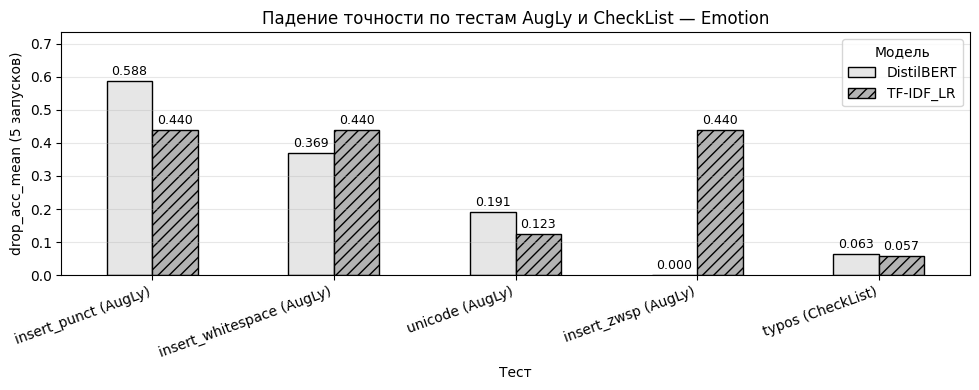

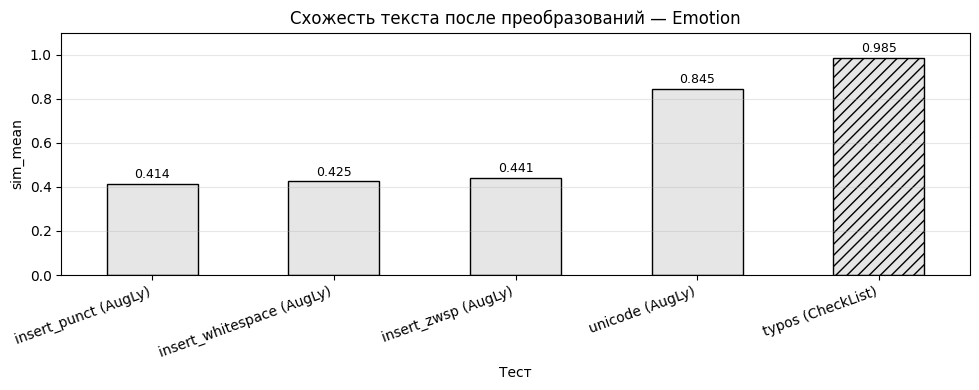

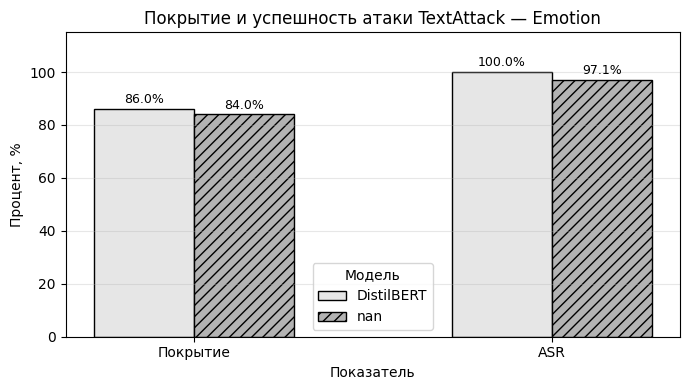

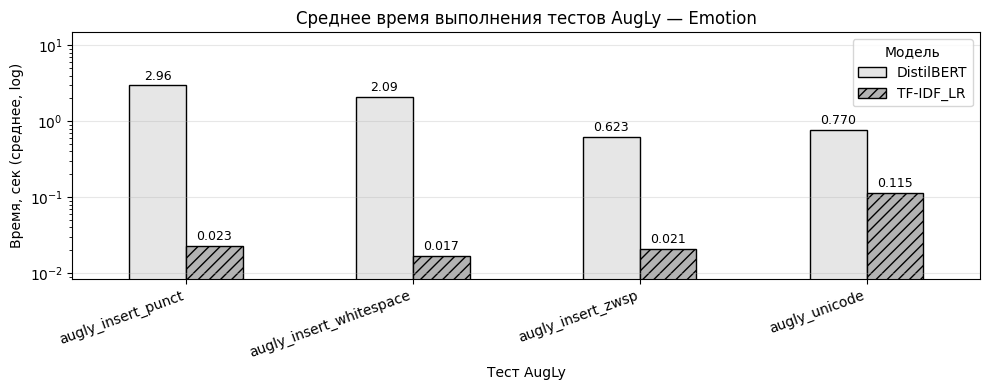

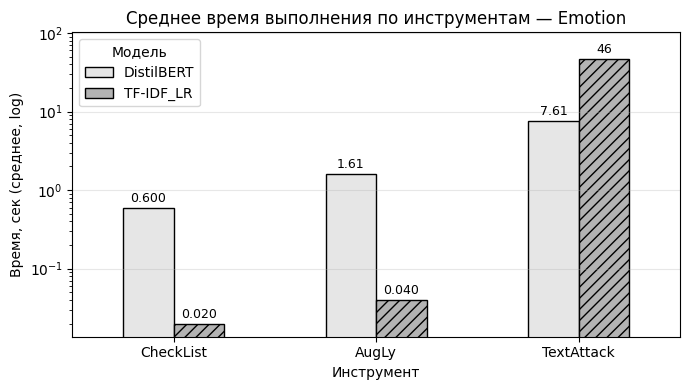

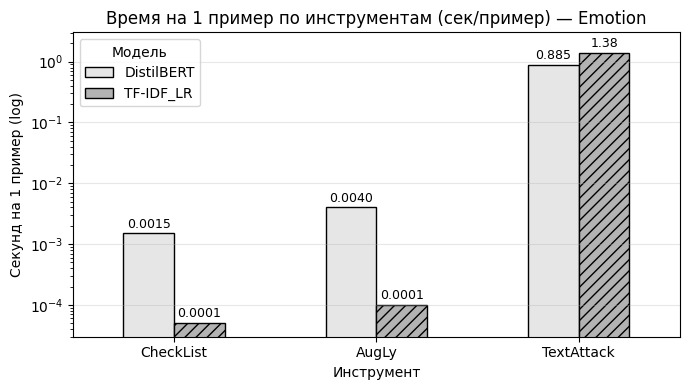

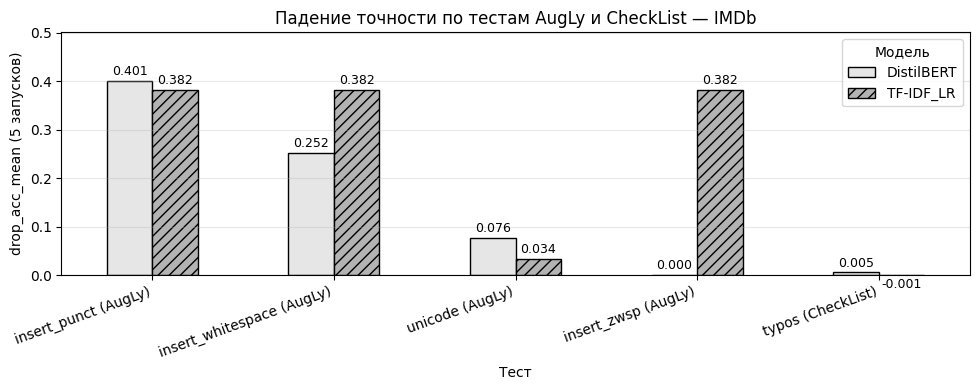

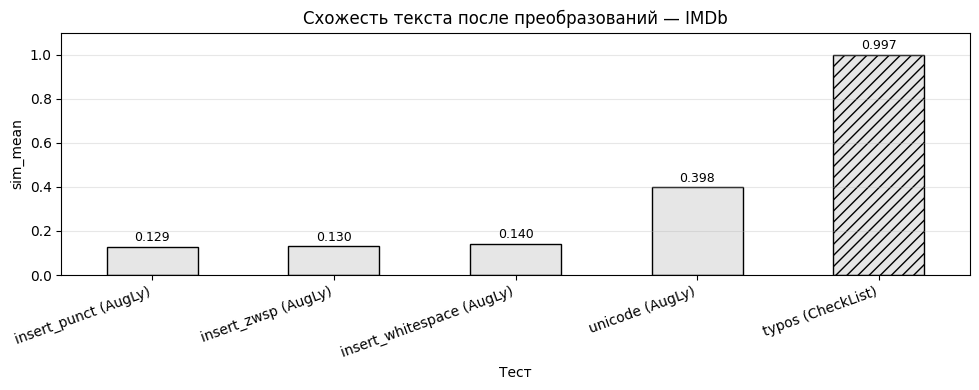

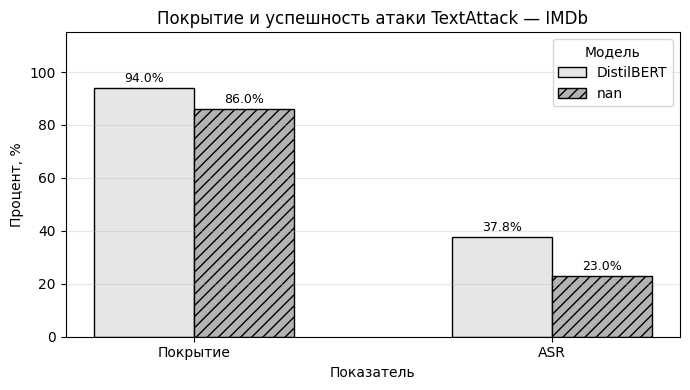

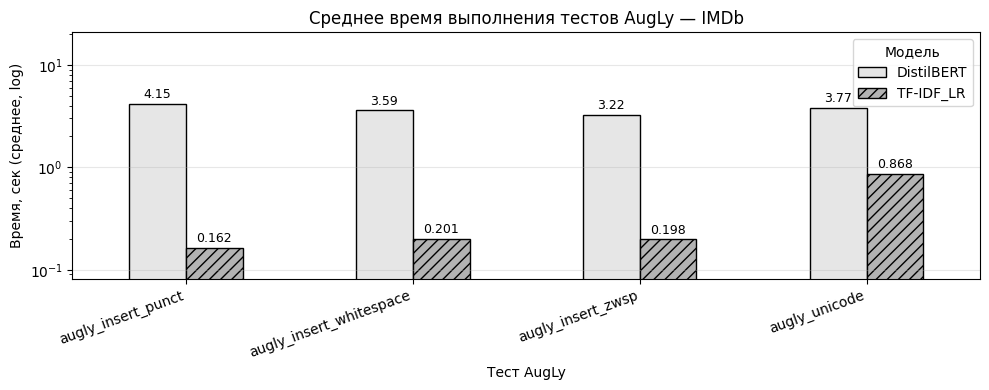

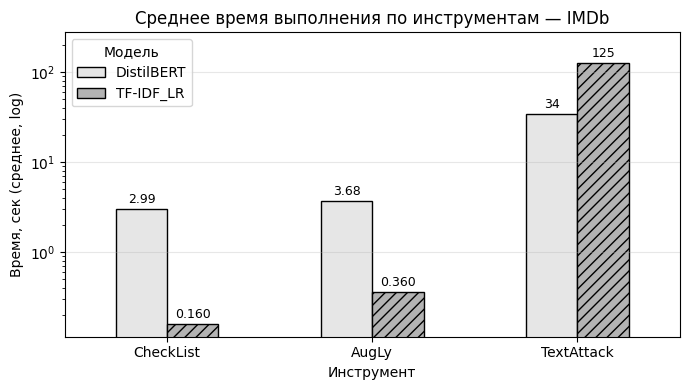

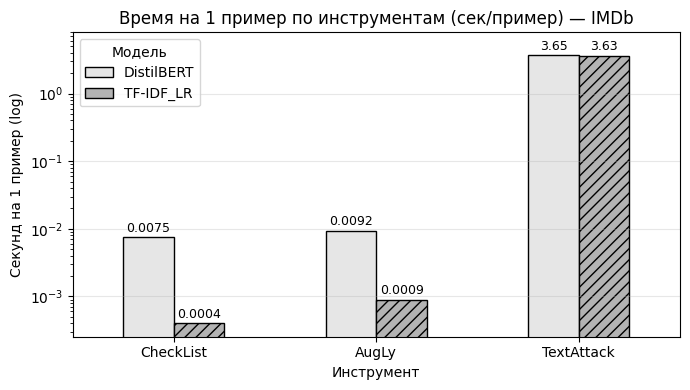

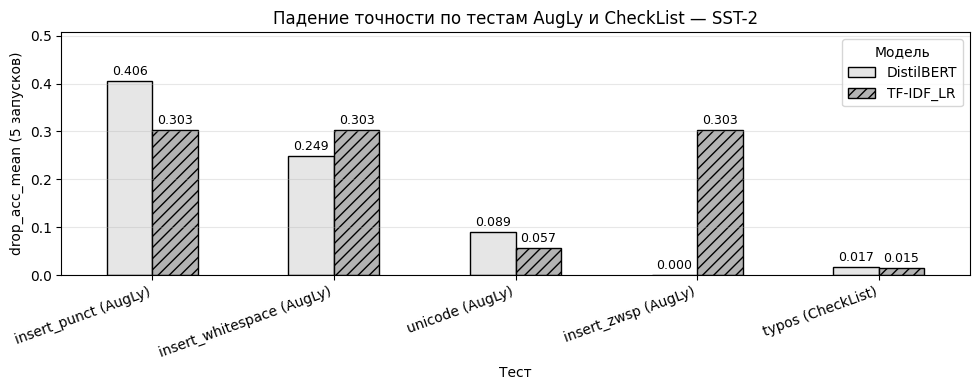

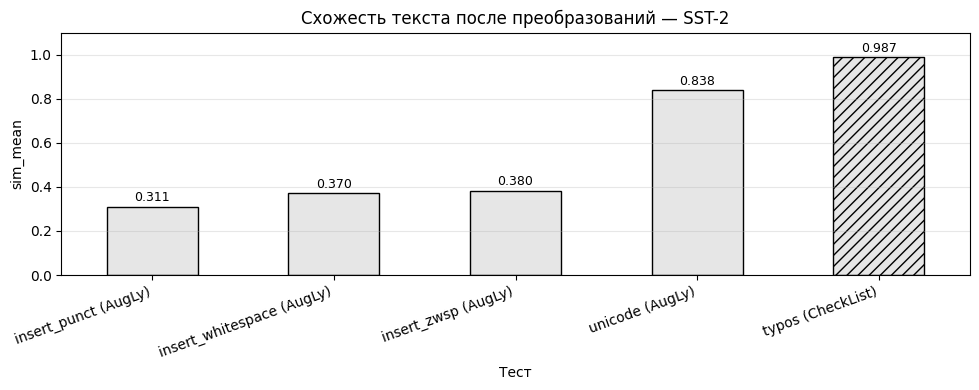

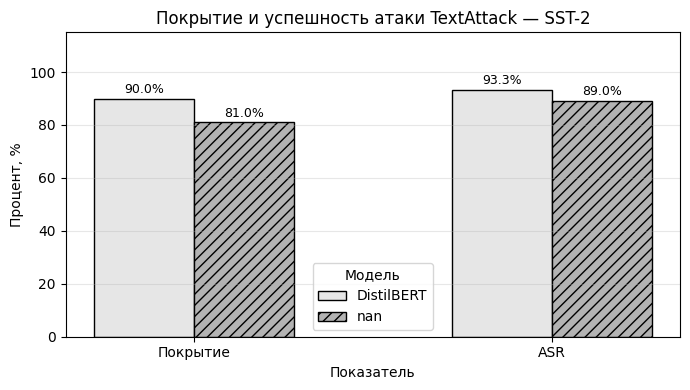

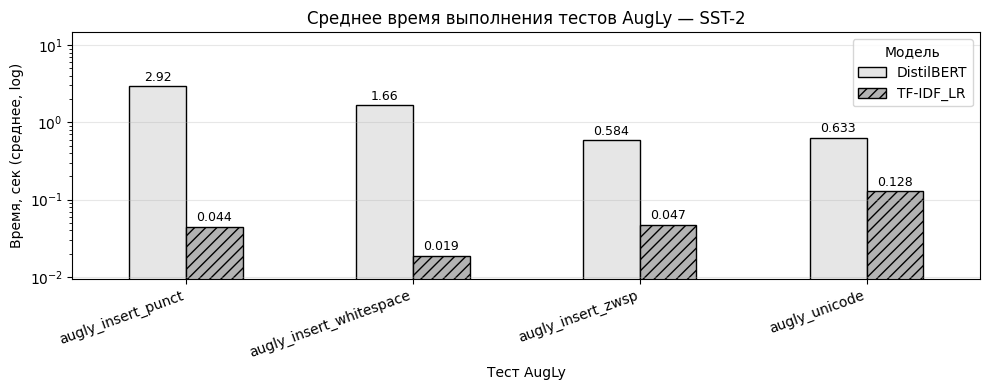

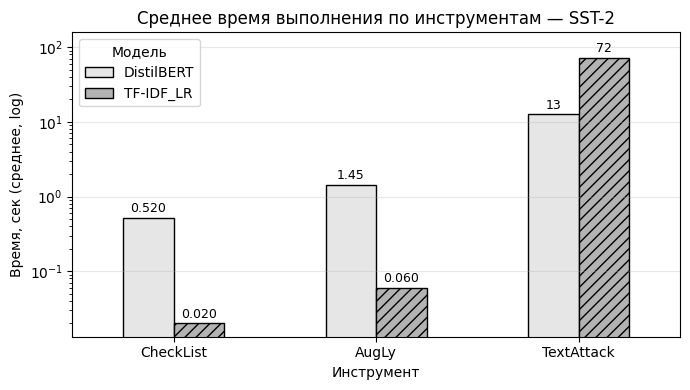

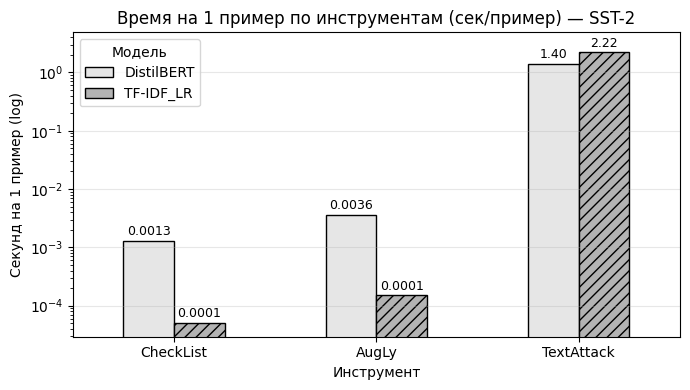

In [ ]:
summary_path = os.path.join(run_dir, "summary_by_test.csv")
overall_path = os.path.join(run_dir, "table_overall_tools_by_dataset.csv")
table_augly_path = os.path.join(run_dir, "table_augly.csv")

datasets = sorted(df[dataset_col].dropna().unique().tolist())

for ds_key in datasets:
    plot_drop_acc_aug_check(summary_path, ds_key)
    plot_similarity_aug_check(summary_path, ds_key)
    plot_textattack_cov_asr(overall_path, ds_key)
    plot_augly_time(table_augly_path, ds_key)
    plot_tool_time(overall_path, ds_key)
    plot_sec_per_example(overall_path, summary_path, ds_key)


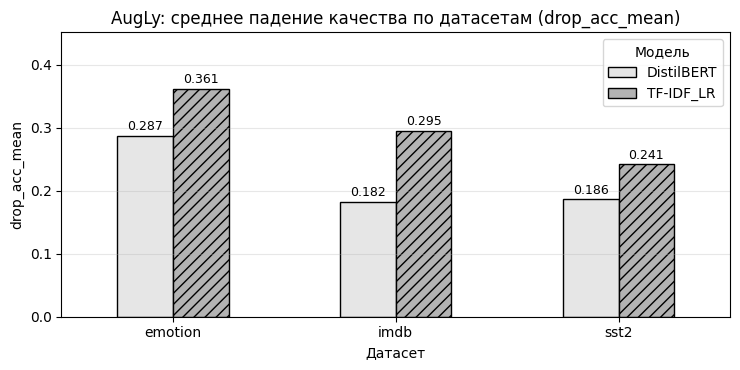

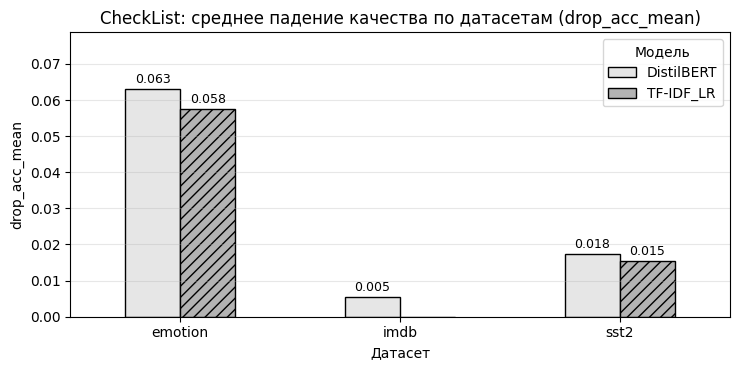

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C1 = "#E6E6E6"
C2 = "#B3B3B3"
HATCH2 = "///"

model_names = {"sk_tfidf_lr": "TF-IDF_LR", "hf_distilbert": "DistilBERT"}  # без "+"
tool_names  = {"augly": "AugLy", "checklist": "CheckList", "textattack": "TextAttack"}

def plot_drop_by_dataset_for_tool(overall_path, tool_key, metric="drop_acc_mean"):
    o = pd.read_csv(overall_path)

    ds_col = "dataset_key" if "dataset_key" in o.columns else ("dataset" if "dataset" in o.columns else None)
    if ds_col is None:
        raise ValueError("Не нашла dataset_key/dataset в overall таблице")

    d = o[o["tool"] == tool_key].copy()
    if len(d) == 0:
        print("No data for tool:", tool_key)
        return

    d["Модель"] = d["model"].map(model_names).fillna(d["model"])
    d["Датасет"] = d[ds_col].astype(str)

    pivot = d.pivot(index="Датасет", columns="Модель", values=metric)
    pivot = pivot.loc[pivot.index.tolist()]

    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(7.5, 3.8))

    for i, container in enumerate(ax.containers):
        for bar in container:
            if i == 1:
                bar.set_hatch(HATCH2)

    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            labels.append("" if pd.isna(v) else f"{float(v):.3f}")
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    ax.set_title(f"{tool_names.get(tool_key, tool_key)}: среднее падение качества по датасетам ({metric})")
    ax.set_xlabel("Датасет")
    ax.set_ylabel(metric)
    ax.grid(True, axis="y", alpha=0.3)

    ymax = float(np.nanmax(pivot.values))
    ax.set_ylim(0, max(0.001, ymax * 1.25))

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

overall_path = os.path.join(run_dir, "table_overall_tools_by_dataset.csv")

plot_drop_by_dataset_for_tool(overall_path, "augly", metric="drop_acc_mean")
plot_drop_by_dataset_for_tool(overall_path, "checklist", metric="drop_acc_mean")


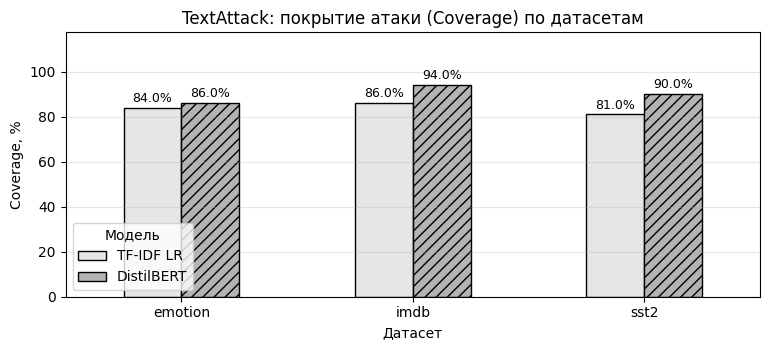

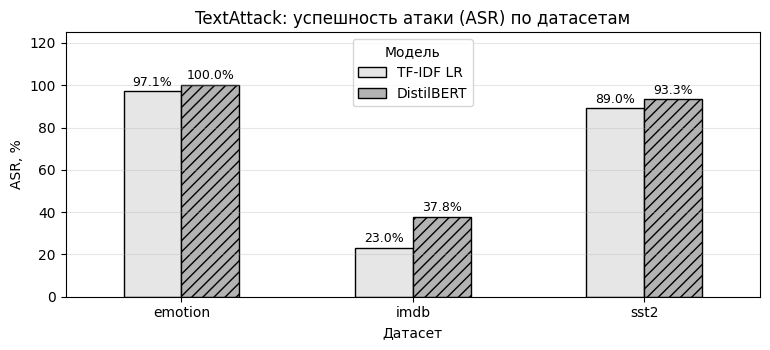

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

overall_path = os.path.join(run_dir, "table_overall_tools_by_dataset.csv")
df = pd.read_csv(overall_path)

ds_col = "dataset_key" if "dataset_key" in df.columns else ("dataset" if "dataset" in df.columns else None)
if ds_col is None:
    raise ValueError("Не нашла dataset_key/dataset в table_overall_tools_by_dataset.csv")

d = df[df["tool"] == "textattack"].copy()
if len(d) == 0:
    raise ValueError("В overall таблице нет строк tool == 'textattack'")

model_names = {"sk_tfidf_lr": "TF-IDF LR", "hf_distilbert": "DistilBERT"}
d["Модель"] = d["model"].map(model_names).fillna(d["model"])
d["Coverage"] = (1.0 - pd.to_numeric(d["fail_rate_mean"], errors="coerce")) * 100.0
d["ASR"] = pd.to_numeric(d["asr_mean"], errors="coerce") * 100.0


datasets = d[ds_col].astype(str).dropna().unique().tolist()
order_models = ["TF-IDF LR", "DistilBERT"]
d["Модель"] = pd.Categorical(d["Модель"], categories=order_models, ordered=True)
d = d.sort_values([ds_col, "Модель"])

pivot_cov = d.pivot(index=ds_col, columns="Модель", values="Coverage").reindex(datasets)
pivot_asr = d.pivot(index=ds_col, columns="Модель", values="ASR").reindex(datasets)

C1 = "#E6E6E6"
C2 = "#B3B3B3"
HATCH2 = "///"

def plot_two_model_bar(pivot, title, ylabel):
    ax = pivot.plot(kind="bar", color=[C1, C2], edgecolor="black", figsize=(7.8, 3.6))

    for i, container in enumerate(ax.containers):
        for bar in container:
            if i == 1:
                bar.set_hatch(HATCH2)

    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            labels.append("" if pd.isna(v) else f"{float(v):.1f}%")
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    ax.set_title(title)
    ax.set_xlabel("Датасет")
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)

    ymax = float(np.nanmax(pivot.values))
    ax.set_ylim(0, max(10, ymax * 1.25))

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 1) Coverage
plot_two_model_bar(
    pivot_cov,
    title="TextAttack: покрытие атаки (Coverage) по датасетам",
    ylabel="Coverage, %"
)

# 2) ASR
plot_two_model_bar(
    pivot_asr,
    title="TextAttack: успешность атаки (ASR) по датасетам",
    ylabel="ASR, %"
)


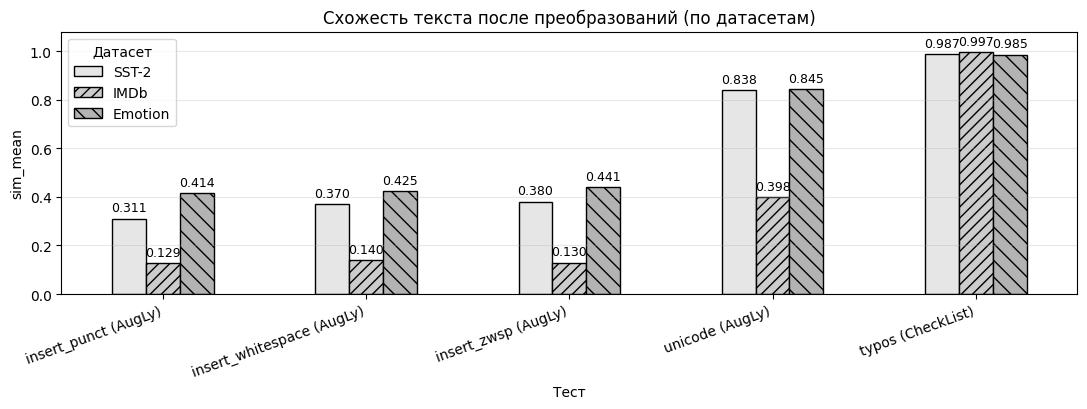

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

path = os.path.join(run_dir, "summary_by_test.csv")
df = pd.read_csv(path)

ds_col = "dataset_key" if "dataset_key" in df.columns else ("dataset" if "dataset" in df.columns else None)
if ds_col is None:
    raise ValueError("Не нашла dataset_key/dataset в summary_by_test.csv")

df = df[df["tool"].isin(["augly", "checklist"])].copy()

tool_names = {"augly": "AugLy", "checklist": "CheckList"}
tool_rank  = {"augly": 0, "checklist": 1}

dataset_names = {
    "sst2": "SST-2",
    "imdb": "IMDb",
    "emotion": "Emotion",
    "glue/sst2": "SST-2",
}

df["Инструмент"] = df["tool"].map(tool_names).fillna(df["tool"])
df["tool_rank"] = df["tool"].map(tool_rank).fillna(99)

def short_test(t):
    t = str(t)
    return t.replace("augly_", "").replace("checklist_", "")

df["Тест"] = df["test_id"].apply(short_test) + " (" + df["Инструмент"] + ")"

agg = (
    df.groupby([ds_col, "Тест", "tool_rank"], as_index=False)
      .agg(sim_mean=("sim_mean", "mean"))
)

order_rows = (
    agg.groupby(["Тест", "tool_rank"], as_index=False)["sim_mean"]
       .mean()
       .sort_values(["tool_rank", "sim_mean"], ascending=[True, True])["Тест"]
       .tolist()
)

pivot = agg.pivot(index="Тест", columns=ds_col, values="sim_mean")
pivot = pivot.reindex(order_rows)
pivot = pivot.rename(columns=lambda x: dataset_names.get(str(x), str(x)))

desired_cols = ["SST-2", "IMDb", "Emotion"]
cols = [c for c in desired_cols if c in pivot.columns] + [c for c in pivot.columns if c not in desired_cols]
pivot = pivot[cols]

ax = pivot.plot(
    kind="bar",
    figsize=(11, 4.2),
    edgecolor="black",
    color=["#E6E6E6", "#CCCCCC", "#B3B3B3"][:len(pivot.columns)]
)

hatches = ["", "///", "\\\\", "xx"]
for i, container in enumerate(ax.containers):
    for bar in container:
        bar.set_hatch(hatches[i % len(hatches)])

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.3f}" if pd.notna(v) else "" for v in container.datavalues],
        padding=3,
        fontsize=9
    )

ax.set_title("Схожесть текста после преобразований (по датасетам)")
ax.set_xlabel("Тест")
ax.set_ylabel("sim_mean")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(title="Датасет")

ax.margins(y=0.12)
ymax = float(pivot.max().max()) if pivot.size else 1.0
ax.set_ylim(0, min(1.08, ymax * 1.25 + 0.05))

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
